In [12]:
import numpy as np
import pickle
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import re

# Preprocessing

In [10]:
def remove_patterns(text):
    text = text.lower()
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove '<user>'
    text = re.sub(r'<user>', '', text)
    # Remove '<url>'
    text = re.sub(r'<url>', '', text)
    return text

# List of models to evaluate

In [5]:
model_0 = naive_bayes.MultinomialNB()
model_1 = linear_model.LogisticRegression()
model_2 = RandomForestClassifier()
model_3 = DecisionTreeClassifier()

# Create a list of models
model_list = [model_0, model_1, model_2, model_3]
model_list

[LogisticRegression(),
 RandomForestClassifier(),
 SVC(),
 DecisionTreeClassifier()]

# Roc

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def train_model(models, embedding, train_df, test_df):
    plt.figure(figsize=(8, 6))
    for this_model in models:
        vec = embedding
        vec.fit(train_df.text)
        xtrain = vec.transform(train_df.text) 
        xtest = vec.transform(test_df.text)
        model = this_model
        model.fit(xtrain, train_df.sentiment)
        pred_probs = model.predict_proba(xtest)[:, 1]
        fpr, tpr, thresholds = roc_curve(test_df.sentiment, pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{str(this_model)} (AUC = {roc_auc:.2f})')
        preds = model.predict(xtest)
        accuracy = metrics.accuracy_score(test_df.sentiment, preds)
        f1 = f1_score(test_df.sentiment, preds)
        print("model:", str(this_model))
        print(f"Accuracy = {accuracy}")
        print(f"F1 Score = {f1}")
        print("")
        # # save the model
        # with open('model_name.pkl', 'wb') as file:
        #     pickle.dump(model, file)
        # with open('vectorizor_name.pkl', 'wb') as file:
        #     pickle.dump(vec, file)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curves')
    plt.legend()
    plt.show()

# Load the data

In [11]:
pos_path = 'data/twitter-datasets/train_pos.txt'
neg_path = 'data/twitter-datasets/train_neg.txt'
with open(pos_path, 'r') as f:
    pos = f.readlines()
pos = [remove_patterns(tweet.rstrip('\n')) for tweet in pos]
with open(neg_path,'r') as f:
    neg = f.readlines()
neg = [remove_patterns(tweet.rstrip('\n')) for tweet in neg]
pos_df = pd.DataFrame({'text': pos, 'sentiment': 1})
neg_df = pd.DataFrame({'text': neg, 'sentiment': -1})
df = pd.concat([pos_df, neg_df], axis=0) 
shuffled_df = df.sample(frac=1).reset_index(drop=True)
y = shuffled_df.sentiment.values
train_size = int(len(shuffled_df) * 0.8)
train_df = shuffled_df.sample(n=train_size, random_state=42)
test_df = shuffled_df.drop(train_df.index)

# Bags of words

c:\Users\Welkin\AppData\Local\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model: LogisticRegression()
Accuracy = 0.82465
F1 Score = 0.8308248914616498



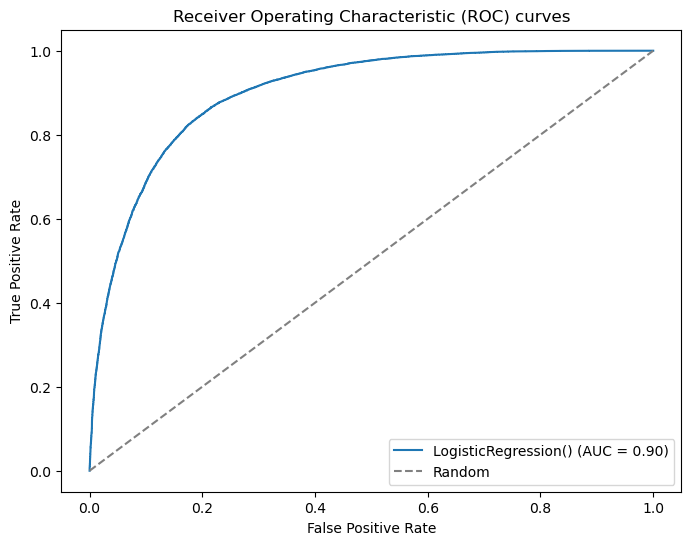

In [9]:
emb = CountVectorizer( 
        tokenizer=word_tokenize, 
        token_pattern=None
    )
train_model(model_list,emb,train_df,test_df)

# create a sbumission

In [ ]:
# load and do the same preprocessing for the test data 
with open('./data/test_data.txt', 'r') as file:
    test_data = file.readlines()
test_data = [remove_patterns(tweet.rstrip('\n')) for tweet in test_data]
test_df = pd.DataFrame({'text': test_data})

with open('count_vectorizer.pkl', 'rb') as file:
    count_vec = pickle.load(file)
test = count_vec.transform(test_df.text) 

# load the model and predict
with open('naive_lr.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

predicted = loaded_model.predict(test)
submission = pd.DataFrame({'Id':range(1, len(test_data) + 1),'Prediction': predicted})
submission.to_csv('submission.csv', index=False) 

# TF-IDF with N-gram

In [17]:
emb = TfidfVectorizer(
        tokenizer=word_tokenize, 
        token_pattern=None, 
        ngram_range=(1, 3)
    )
train_model(model_list,emb,train_df,test_df)

c:\Users\Welkin\AppData\Local\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold: 0
Accuracy = 0.83655

Fold: 1
Accuracy = 0.8392

Fold: 2
Accuracy = 0.836175



c:\Users\Welkin\AppData\Local\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
# load and do the same preprocessing for the test data 
with open('./data/test_data.txt', 'r') as file:
    test_data = file.readlines()
test_data = [remove_patterns(tweet.rstrip('\n')) for tweet in test_data]
test_df = pd.DataFrame({'text': test_data})

with open('tfid.pkl', 'rb') as file:
    tfidf_vec = pickle.load(file)
test = tfidf_vec.transform(test_df.text) 

# load the model and predict
with open('tfidf.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

predicted = loaded_model.predict(test)
submission = pd.DataFrame({'Id':range(1, len(test_data) + 1),'Prediction': predicted})
submission.to_csv('tf_submission.csv', index=False) 